In [21]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim

In [22]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [23]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [24]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [25]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [26]:
# 初期値を指定
initial_params = {
    'k1': -8.307060241699219,  # 指定した初期値に変更
    'k2': 0.8844702243804932,
    'k3': 0.06974875926971436,
    'k4': 8.433136940002441,
    'k5': -1.2938456535339355,
    'k6': -1.9883843660354614,
    't1': 7.459859371185303,
    'p1': 72.52159118652344,
    't2': 88.79557800292969,
    'p2': 25.29776954650879
}

# パラメータをtorch.nn.Parameterに変換
k1 = torch.nn.Parameter(torch.tensor(initial_params['k1'], dtype=torch.float32))
k2 = torch.nn.Parameter(torch.tensor(initial_params['k2'], dtype=torch.float32))
k3 = torch.nn.Parameter(torch.tensor(initial_params['k3'], dtype=torch.float32))
k4 = torch.nn.Parameter(torch.tensor(initial_params['k4'], dtype=torch.float32))
k5 = torch.nn.Parameter(torch.tensor(initial_params['k5'], dtype=torch.float32))
k6 = torch.nn.Parameter(torch.tensor(initial_params['k6'], dtype=torch.float32))
t1 = torch.nn.Parameter(torch.tensor(initial_params['t1'], dtype=torch.float32))
p1 = torch.nn.Parameter(torch.tensor(initial_params['p1'], dtype=torch.float32))
t2 = torch.nn.Parameter(torch.tensor(initial_params['t2'], dtype=torch.float32))
p2 = torch.nn.Parameter(torch.tensor(initial_params['p2'], dtype=torch.float32))

# 最適化アルゴリズムのセットアップ
optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-1)

# 特定の組み合わせ（例: perm1=(0, 1, 2), perm2=(0, 1, 2)）
perm1 = (0, 1, 2)
perm2 = (0, 1, 2)

# エポックごとのトレーニング
prev_loss = float('inf')
for epoch in range(300000):
    optimizer.zero_grad()

    # モデルを使って出力を計算
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    # シフト1とシフト2の計算
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

    # 損失関数の計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    # ロスが増加した場合、トレーニングを終了
    if loss.item() > prev_loss:
        print(f"Loss increased at epoch {epoch}. Stopping training.")
        break

    # ロスが最小の場合のパラメータを保存
    prev_loss = loss.item()

    loss.backward()
    optimizer.step()

    # パラメータの範囲を制限
    with torch.no_grad():
        for param in [k1, k2, k3, k4, k5, k6]:
            param.data = torch.clamp(param.data, -10.0, 10.0)
        for param in [t1, p1, t2, p2]:
            param.data = torch.clamp(param.data, 0.0, 90.0)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

Epoch 0, Loss: 0.9626015424728394
Parameters: k1=-8.207059860229492, k2=0.9844701290130615, k3=0.16974873840808868, k4=8.533137321472168, k5=-1.393845558166504, k6=-1.8883843421936035, t1=7.359859466552734, p1=72.42159271240234, t2=88.6955795288086, p2=25.397769927978516
Epoch 100, Loss: 0.008878017775714397
Parameters: k1=-7.912887096405029, k2=0.4879570007324219, k3=0.0034740460105240345, k4=8.575101852416992, k5=-2.213879346847534, k6=-2.4139816761016846, t1=0.8755940794944763, p1=67.44033813476562, t2=89.93183135986328, p2=27.094257354736328
Epoch 200, Loss: 2.6626751150615746e-06
Parameters: k1=-7.9114990234375, k2=0.48551833629608154, k3=5.4514755902346224e-05, k4=8.525564193725586, k5=-2.300528049468994, k6=-2.4453749656677246, t1=0.014822532422840595, p1=67.32250213623047, t2=89.9989013671875, p2=27.11150360107422
Loss increased at epoch 253. Stopping training.


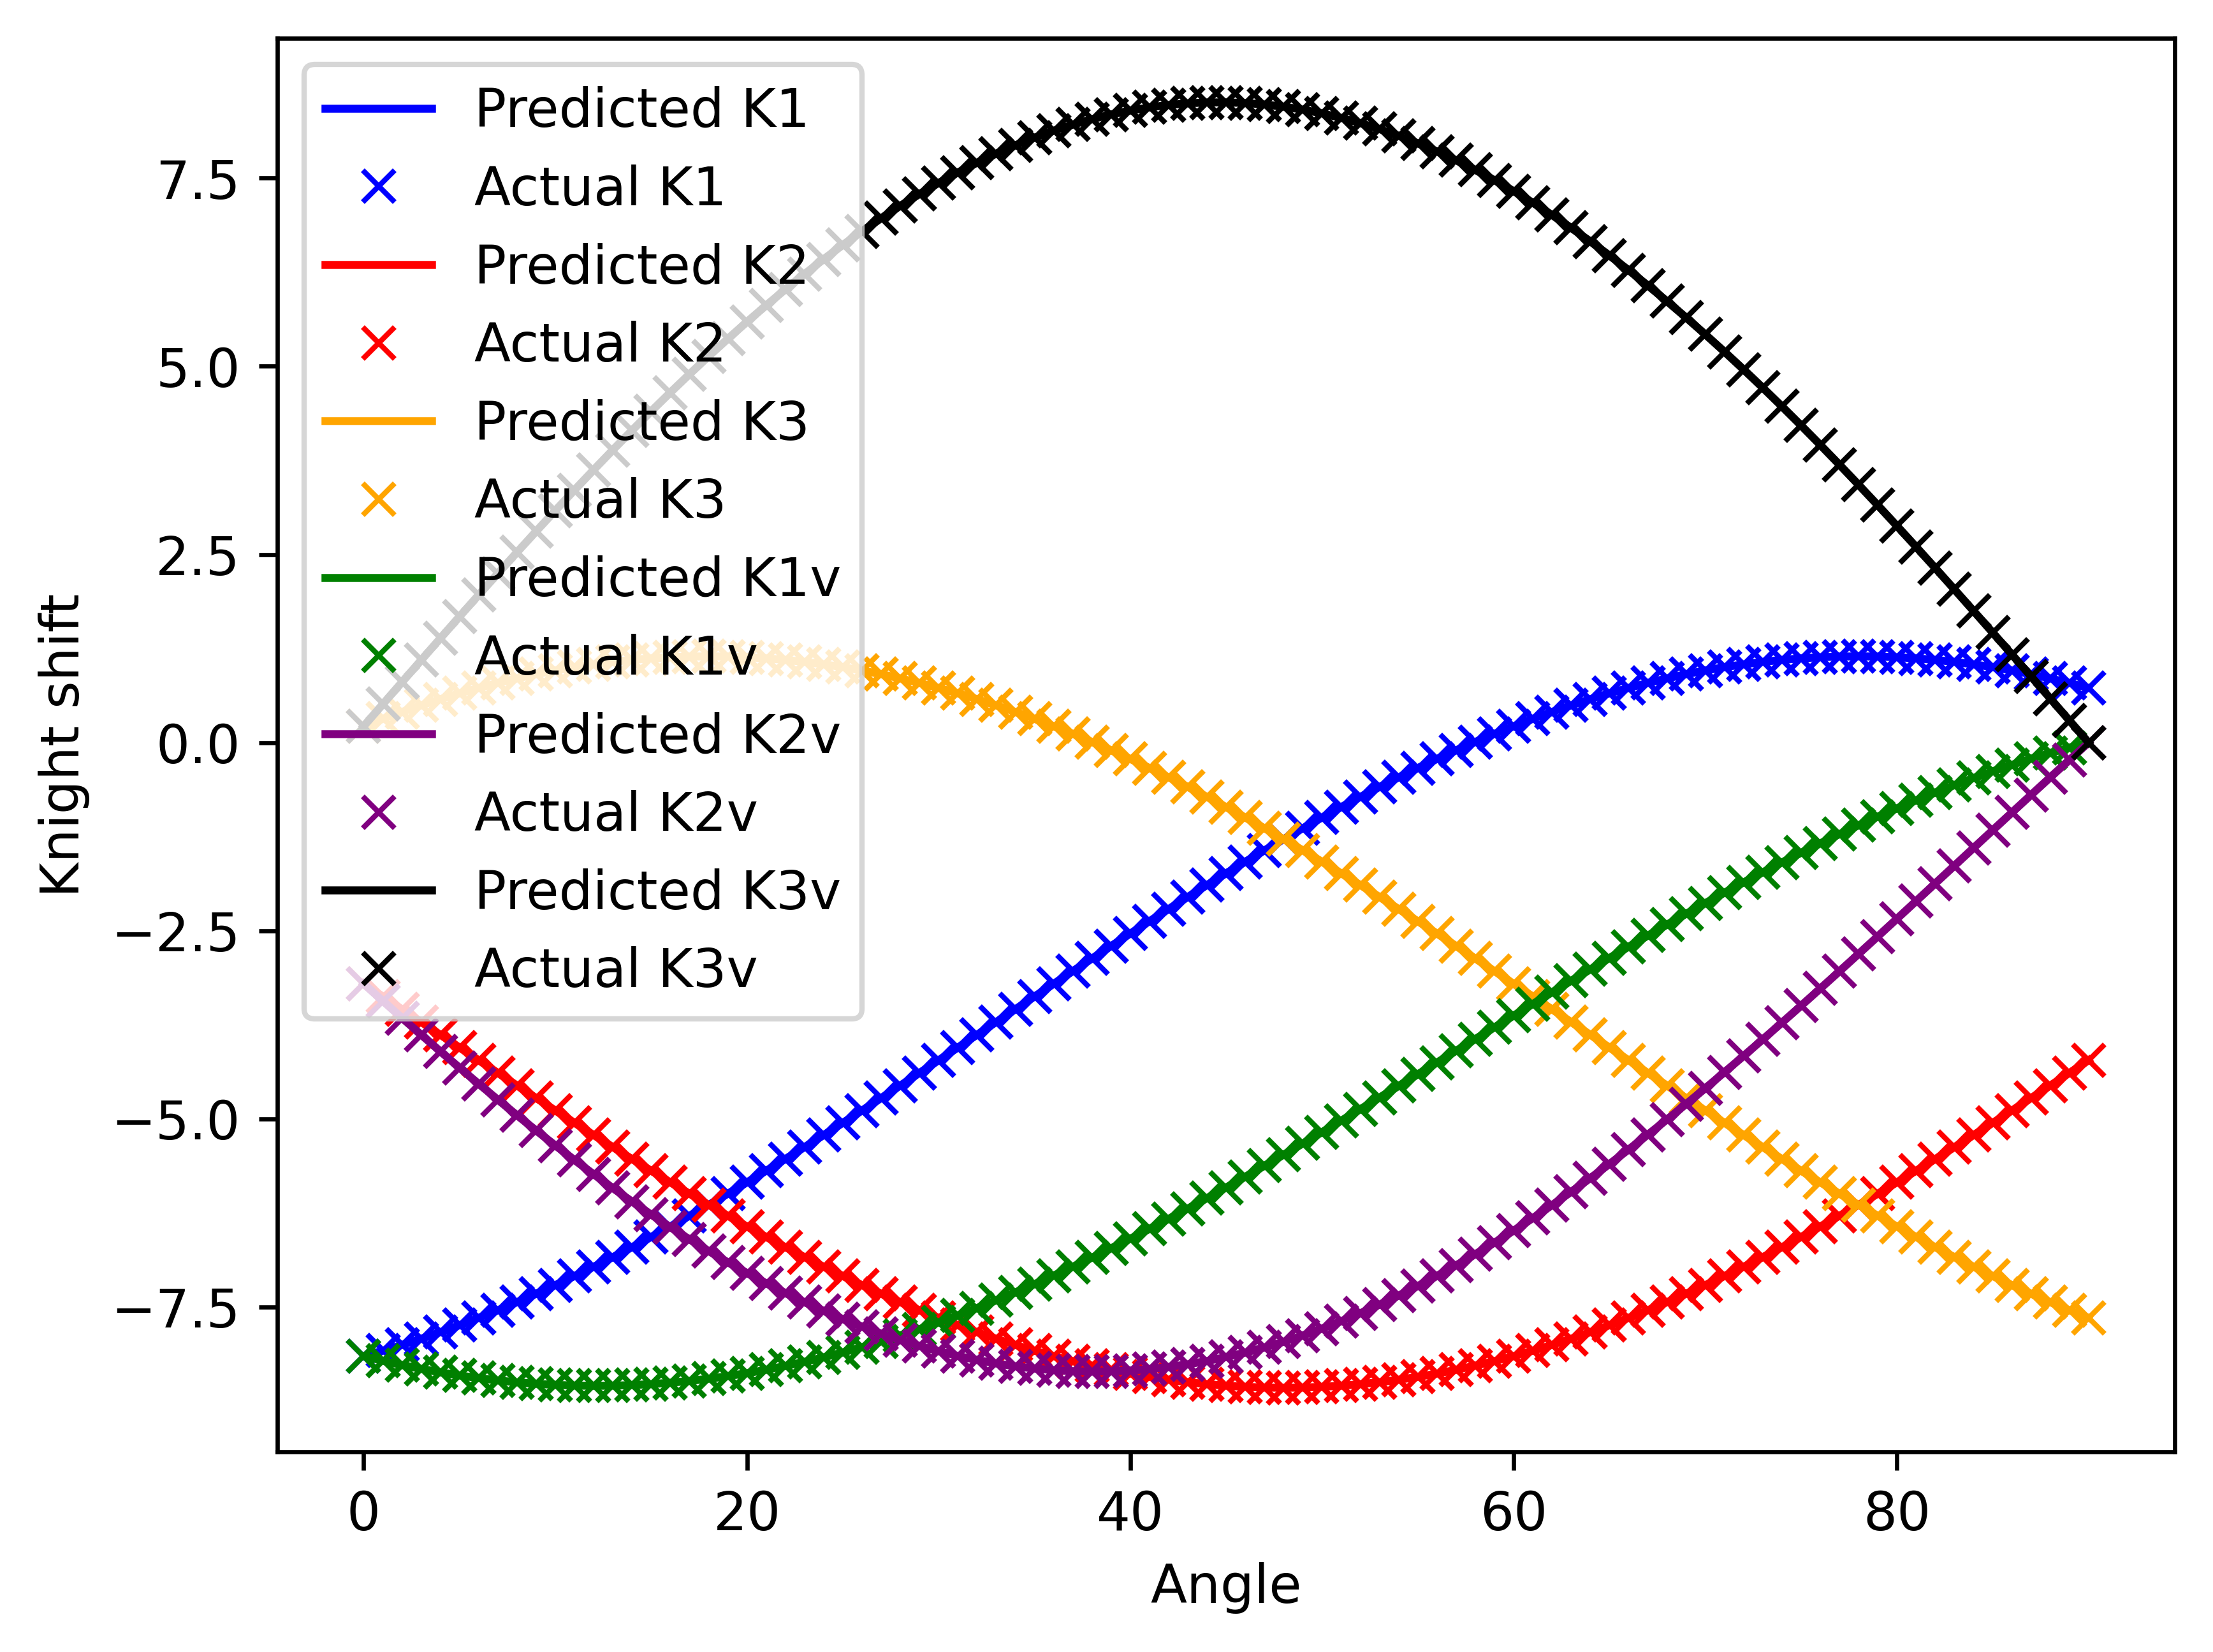

Parameters: k1=-7.911579608917236, k2=0.48558032512664795, k3=-5.37282915047399e-07, k4=8.524683952331543, k5=-2.301881790161133, k6=-2.445774793624878, t1=0.0, p1=67.32243347167969, t2=90.0, p2=27.110910415649414


In [34]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(k1.item())
k2 = torch.tensor(k2.item())
k3 = torch.tensor(k3.item())
k4 = torch.tensor(k4.item())
k5 = torch.tensor(k5.item())
k6 = torch.tensor(k6.item())
t1 = torch.tensor(t1.item())
p1 = torch.tensor(p1.item())
t2 = torch.tensor(t2.item())
p2 = torch.tensor(p2.item())

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'x', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'x', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'x', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'x', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'x', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'x', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')